# Imports

In [1]:
import os
import sys
import pdb
import math
import time
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.path as mpltPath
from sklearn.metrics import pairwise_distances
from scipy.spatial import Delaunay
from scipy.stats import zscore

import random 
from PIL import Image
#Custom helper functions:
sys.path.append('./tls')
from funs import tls
from funs import delaunay as delHelpers
importlib.reload(delHelpers)
importlib.reload(tls)
results = Path('/mnt/results')
base = Path('/mnt/data/TBruno_TMA_Phenotyping/Cell_segmentation/TMA01') #UPMC  apptainer shell -B  ~/HCC-CBS-028-Pfizer-TBruno:/mnt
# txt = [base.joinpath('042420  #02 TMA_Phenotyping #2_Core[1,3,G]_[48599,5654]_cell_seg_data.txt')]
txt = [base.joinpath('042420  #01 TMA_Phenotyping #1_Core[1,1,R]_[62880,6954]_cell_seg_data.txt')]
df = pd.read_csv(txt[0], sep='\t')
df.head(2)

# tls_full = pd.read_pickle('/mnt/results/all_tls_features_with_clinical_UMAP_size_and_pattern.pkl')

,Path,Sample Name,Tissue Category,Phenotype,Cell ID,Total Cells,Tissue Category Area (square microns),Cell Density (per square mm),Cell X Position,Cell Y Position,...,"Entire Cell Autofluorescence Std Dev (Normalized Counts, Total Weighting)","Entire Cell Autofluorescence Total (Normalized Counts, Total Weighting)",Lab ID,Slide ID,TMA Sector,TMA Row,TMA Column,TMA Field,Confidence,inForm 2.4.7110.22652
0,E:\042420 #01 TMA_Phenotyping #1\Scan1\MSI,"042420 #01 TMA_Phenotyping #1_Core[1,1,R]_[62...",Tumor,CD20+,1,NaN,NaN,NaN,62893.8,6380.3,...,0.511,251.201,NaN,042420 #01 TMA_Phenotyping #1,1,1,R,1,87.18%,NaN
1,E:\042420 #01 TMA_Phenotyping #1\Scan1\MSI,"042420 #01 TMA_Phenotyping #1_Core[1,1,R]_[62...",Tumor,CD20+,2,NaN,NaN,NaN,62851.1,6379.8,...,0.320,59.951,NaN,042420 #01 TMA_Phenotyping #1,1,1,R,1,62.76%,NaN


# Add in exploration of Delauney triangulation for neighborhood analysis
As per 2021 Nat. Comm. paper:
"Finally, we analyzed the key cell-cell neighborhoods
associated with TLS with GC vs. TLS without GC in HNSCC (Fig. 6g). In TLS with GC, TIL-Bs interact with other TIL-Bs and CD4+ Tconv TIL, which is in line with the working definition of an active GC. Interestingly, an evaluation of TLS without GC in HNSCC revealed that TIL-Bs were not frequently in the same neighborhood with CD4+ Tconv, and instead CD8+ TIL and Tregs were implicated as a dominant interaction. These results demonstrate that in TLS with GC, the spatial patterning becomes distinct from well-infiltrated tumors where immune cells are found in aggregates."

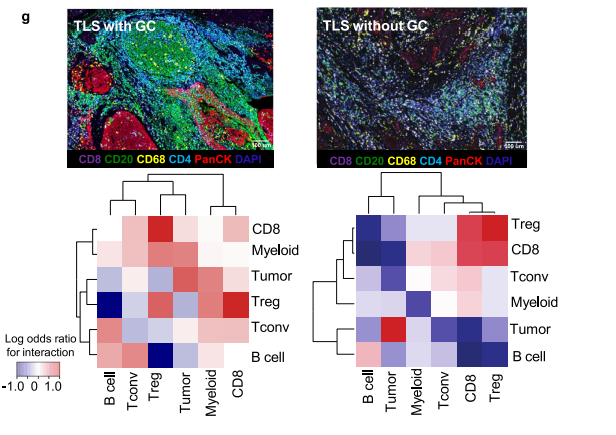

In [2]:
pil_im = Image.open('./nat_comm_2021_neighbors.png')
display(pil_im)

(6543, 4)
['CD20+' 'CD4+' 'CD68+' 'CD8+' 'FoxP3+' 'Others' 'PanCK+']
Cell coords (6543, 2)
13020


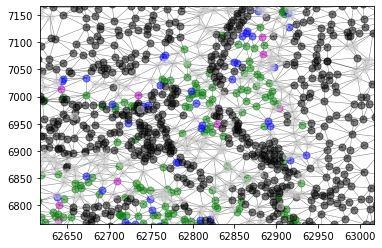

In [2]:
qct = 50
qc = tls.get_qc(df,qc_thresh=qct)
subset=df.loc[qc,('Tissue Category',
                 'Phenotype',
                 'Cell X Position',
                 'Cell Y Position')]
print(subset.shape)
subset.head()
cell_types = np.unique(tls.get_celltypes(subset))
print(cell_types)

#Collect cell positions from following types:
use_cells = [('Phenotype','CD20+'),
             ('Phenotype','CD4+'),
             ('Phenotype','CD8+'),
             ('Phenotype','FoxP3+'),
             ('Phenotype','CD68+'), #('Phenotype','PanCK+')
             ('Phenotype','PanCK+'),
            ('Phenotype','Others')]
idx = np.zeros((1,subset.shape[0])) == 1
for col,cell in use_cells:
    idx = idx | (subset.loc[:,col].values == cell)
points = subset.loc[idx.T,
                    ('Cell X Position',
                     'Cell Y Position')
                   ].values
point_types = subset.loc[idx.T,('Phenotype')].values
tiss_types = subset.loc[idx.T,('Tissue Category')].values

#Make dictionary:
point_lookup={tuple(point):(cell,tissue) \
              for point,cell,tissue in zip(points,point_types,tiss_types)}

print('Cell coords',points.shape)

# Delaunay
tri = Delaunay(points)
print(tri.nsimplex)
plt.triplot(points[:,0], points[:,1],
            tri.simplices,
           color='gray',
           linewidth=0.5)

for col,cell in use_cells:
    idx = subset.loc[:,col].values == cell
    cell_pts=subset.loc[idx.T,
                    ('Cell X Position',
                     'Cell Y Position')
                   ].values
    plt.scatter(cell_pts[:,0],cell_pts[:,1], 
                50,
                marker='o',
                alpha = 0.5,
                color=tls.cell_colormap(cell))
# plt.xlim([48800,48950])
# plt.ylim([5150,5250])
xmed = np.median(points[:,0])
ymed = np.median(points[:,1])
plt.xlim([xmed-200,xmed+200])
plt.ylim([ymed-200,ymed+200])
plt.show()

# Delaunay helper tests

In [40]:
qct = 50
scale = 1
max_dist = 25 #microns
qc = tls.get_qc(df,qc_thresh=qct)
subset=df.loc[qc,('Tissue Category',
                 'Phenotype',
                 'Cell X Position',
                 'Cell Y Position')]

example = 100

point_lookup = delHelpers.df_to_cell_type_dict(subset)
print(point_lookup[tuple(points[example])])

print(example,delHelpers.point_to_vert(points,points[example]))

all_verts = delHelpers.vert_to_connected_verts(example,tri)
print(all_verts)

neighbor_cell_xy  = tri.points[all_verts]
print(delHelpers.point_list_to_celltype(neighbor_cell_xy,point_lookup))

neighbor_cell_xy  = tri.points[all_verts]
print(neighbor_cell_xy)
print(tri.points[example])
print(tri.points[example].reshape(1,-1))
print(tri.points[all_verts[0]])
is_neighbor = delHelpers.cell_dist_criterion(tri.points[example],
                                  neighbor_cell_xy,
                                  radius = max_dist)
print(is_neighbor,len(is_neighbor),len(all_verts))

('Others', 'Tumor')
100 100
[  84   93  107 1992 2025]
[('Others', 'Tumor'), ('Others', 'Tumor'), ('Others', 'Tumor'), ('Others', 'Tumor'), ('Others', 'Tumor')]
[[62739.2  6472.8]
 [62719.3  6475.3]
 [62733.7  6481.2]
 [62730.7  6464.8]
 [62727.2  6480.7]]
[62734.2  6476.3]
[[62734.2  6476.3]]
[62739.2  6472.8]
(array([ True,  True,  True,  True,  True]), array([ 6.10327785, 14.93351937,  4.92544421, 12.02081528,  8.26801065])) 2 5


# Example of going from a point to all neighboring vertices

[   9   30   34   35 3798 3878 3903 3945]
[   1    9   30   34   35 3798 3878 3903 3945    1]
[False False  True  True  True False  True  True  True False]


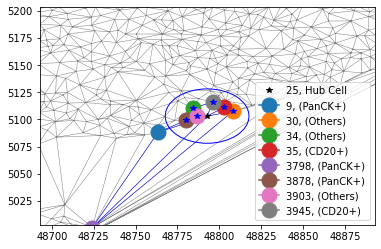

In [33]:
# for file 042420  #02 TMA_Phenotyping #2_Core[1,3,G]_[48599,5654]_cell_seg_data.txt' in TMA02
vert = 25
plt.plot(tri.points[vert,0],tri.points[vert,1],'k*',
        label='%d, Hub Cell' % vert)

all_verts = vert_to_connected_verts(vert, tri)
print(all_verts)

plt.triplot(points[:,0], points[:,1],
            tri.simplices,
           color='gray',
           linewidth=0.5)

all_simp_with_vert = [i for i,s in enumerate(tri.simplices) \
                      if vert in s]
plt.triplot(points[:,0], points[:,1],
        tri.simplices[all_simp_with_vert],
        color='b',
        linewidth=0.5)
p = []
for vert_i in all_verts:
    cell_type = point_lookup[tuple(tri.points[vert_i])]
    label = '%d, (%s)' % (vert_i,cell_type[0])
    plt.plot(points[vert_i,0],points[vert_i,1],
             marker='o',
             label=label,
             markersize=15)
plt.legend()
win = 200
xmin = tri.points[vert,0] - (win/2)
xmax = xmin+ win

ymin = tri.points[vert,1] - (win/2)
ymax = ymin+ win
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

radius = 25
scale = 1# 0.4972 # * 10
#Test that logical index order maps correctly:
all_verts = np.concatenate((np.array([1]),
                            all_verts,
                            np.array([1])))
print(all_verts)

is_neighbor, dist = cell_dist_criterion(tri.points[vert],
                                  tri.points[all_verts],
                                  radius = radius,
                                  scale = scale)
print(is_neighbor)
tls.plot_circle(tri.points[vert],
                radius/scale, #Scale micron to pixels
                plt.gca())
is_neighbor,dist = cell_dist_criterion(tri.points[vert],
                                  tri.points[all_verts],
                                  radius = radius)
plt.plot(tri.points[all_verts[is_neighbor],0],
         tri.points[all_verts[is_neighbor],1],
         'b*')

# For each cell of each time, count the # connections to each cell vs. not that cell type (odds)

In [6]:
# Keep in mind that this example core does not have any AF/Macrophage clusters:
col,cell = ('Tissue Category', 'AF/Macrophage Cluster')
idx = (subset.loc[:,col].values == cell) 
print(np.unique(subset.loc[:,col]))
print(cell,':', np.sum(idx))

['Immune Cell Cluster' 'Others' 'Tumor']
AF/Macrophage Cluster : 0


# Example on one file. see batch_delaunay folder for HPC method for running on all cores in parallel!

In [ ]:
import time
start = time.time()
qct = 50
scale = 1
max_dist = 25 #microns
qc = tls.get_qc(df,qc_thresh=qct)
subset=df.loc[qc,('Tissue Category',
                 'Phenotype',
                 'Cell X Position',
                 'Cell Y Position')]

point_lookup = delHelpers.df_to_cell_type_dict(subset)
points = subset.loc[:,('Cell X Position',
                       'Cell Y Position')
                       ].values   
tri = Delaunay(points)

use_cells = [('Phenotype', 'CD20+'),
             ('Phenotype', 'CD4+'),
             ('Phenotype', 'CD8+'),
             ('Phenotype', 'CD68+'),
             ('Phenotype','FoxP3+'),
             ('Phenotype', 'PanCK+'),
             ('Tissue Category', 'Tumor'),
             ('Tissue Category', 'Immune Cell Cluster'),
             ('Tissue Category', 'AF/Macrophage Cluster'),
            ]

cell_names = ['CD20+',
              'CD4+',
              'CD8+',
              'CD68+',
              'FoxP3+',
              'PanCK+',
              'Tumor',
              'Immune Cell Cluster',
              'AF/Macrophage Cluster']

i = 0
connections = pd.DataFrame()
print('Beginning connection mapping...')
for col,cell in use_cells:
    idx = (subset.loc[:,col].values == cell)
    hub_cell_points = subset.loc[idx.T,
                        ('Cell X Position',
                         'Cell Y Position')
                       ].values    
    hub_ids = subset.index[idx.T] #Will allow easier mapping back to x,y coordinates later if desired
    
    #For each hub cell type, count types of connections    
    for i, hub in zip(hub_ids, hub_cell_points):
        vert = delHelpers.point_to_vert(tri.points, hub)
        if isinstance(vert,int) and (not np.isnan(vert)):
            connected_verts = delHelpers.vert_to_connected_verts(vert, tri)
            connected_points = tri.points[connected_verts]

            #Filter out cells > 100um away:
            is_neighbor, dists = delHelpers.cell_dist_criterion(tri.points[vert],
                                      connected_points,
                                      radius = max_dist,
                                      scale = scale)
            cx_ids = connected_verts[is_neighbor]
            connected_points = connected_points[is_neighbor]
            connected_dists = dists[is_neighbor]
            spoke_cell_types = delHelpers.point_list_to_celltype(connected_points, point_lookup)
            temp = pd.DataFrame(spoke_cell_types, columns = ['cx_cell','cx_tissue'])
            temp['dist_um'] = connected_dists
            temp['hub_id'] = i
            temp['cx_id'] = cx_ids
            temp['hub_cell'] = cell       
            connections = pd.concat((connections,temp),axis=0)
        
stop = time.time()
print((stop-start)/60)
print('Finished')
connections.reset_index(drop=True).head()  
# out_fn = output.joinpath('neighborhoods').joinpath('test2.csv')
# connections.to_csv(out_fn)
    

In [31]:
connections.head(8)

,cx_cell,cx_tissue,dist_um,hub_id,cx_id,hub_cell
0,Others,Tumor,16.016242,25,30,CD20+
1,Others,Tumor,11.194642,25,34,CD20+
2,CD20+,Immune Cell Cluster,12.744018,25,35,CD20+
3,PanCK+,Tumor,13.505925,25,3878,CD20+
4,Others,Tumor,5.900000,25,3903,CD20+
5,CD20+,Immune Cell Cluster,13.366376,25,3945,CD20+
0,CD20+,Tumor,12.744018,36,25,CD20+
1,Others,Tumor,6.435060,36,30,CD20+


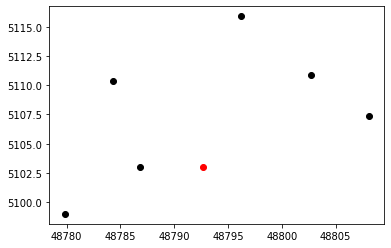

In [32]:
use = np.array([30,34,35,3878,3903,3945])
plt.plot(tri.points[use,0],tri.points[use,1],'ok')
plt.plot(tri.points[25,0],tri.points[25,1],'ro')

# Saving / loading this output ~4mb .csv file size not too bad.

In [82]:
out_fn = results.joinpath('neighborhoods').joinpath('test.csv')
connections.to_csv(out_fn)

In [7]:
# out_fn = results.joinpath('neighborhoods').joinpath('test.csv')
out_fn = results.joinpath('neighborhods/v0').joinpath(
connections = pd.read_csv(out_fn)
connections.head()

,Unnamed: 0,cx_cell,cx_tissue,hub_id,hub_cell
0,0,PanCK+,Tumor,0,CD20+
1,1,Others,Tumor,0,CD20+
2,2,Others,Tumor,0,CD20+
3,3,CD20+,Immune Cell Cluster,0,CD20+
4,4,PanCK+,Others,0,CD20+


# Example: calculate log odds of connectivity

Text(32.99999999999999, 0.5, 'Spoke cell')

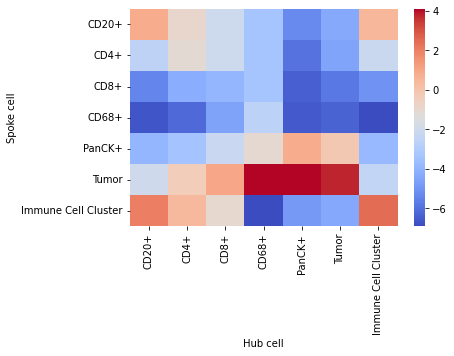

In [8]:
cell_names = ['CD20+',
              'CD4+',
              'CD8+',
              'CD68+',
              'FoxP3+',
              'PanCK+',
              'Tumor',
              'Immune Cell Cluster',
             ] #     none of these in example core:  'AF/Macrophage Cluster'

cx_cells = ['CD20+',
              'CD4+',
              'CD8+',
              'CD68+',
              'FoxP3+',
              'PanCK+']

cx_tissues = ['Tumor',
              'Immune Cell Cluster',
              'AF/Macrophage Cluster']

use_cells = connections.loc[:,'cx_cell'].isin(cell_names)
use_tissues = use_cells = connections.loc[:,'cx_tissue'].isin(cell_names)
use_cx = use_cells | use_tissues

output = np.zeros((len(cell_names),len(cell_names)))
for i,hub_type in enumerate(cell_names):
    for j,spoke_type in enumerate(cell_names):
        use_hub = connections.loc[:,'hub_cell'].values == hub_type
        if any([spoke_type == x for x in cx_tissues]):
            use_spoke = connections.loc[:,'cx_tissue'] == spoke_type
        else:
            use_spoke = connections.loc[:,'cx_cell'] == spoke_type
        a = np.sum(use_hub & use_spoke) #Total n connections of hub-type i to spoke-type j.
        na = np.sum(use_hub & ~use_spoke) #Total n connections of hub-type i to Not spoke-type j.
        output[j,i] = a / na
output = np.log(output+.01)

sns.heatmap(output,
            cmap = 'coolwarm',
            xticklabels=cell_names,
            yticklabels=cell_names)
plt.xlabel('Hub cell')
plt.ylabel('Spoke cell')
plt.title(txt[0].parts[-1]);
    

In [49]:
connections.head()

,Unnamed: 0,cx_cell,cx_tissue,dist_um,hub_id,cx_id,hub_cell
0,0,CD4+,Immune Cell Cluster,15.689487,152,82,CD20+
1,1,Others,Immune Cell Cluster,14.933519,152,2818,CD20+
2,2,CD4+,Immune Cell Cluster,12.907750,152,2840,CD20+
3,3,CD4+,Immune Cell Cluster,5.700877,152,2850,CD20+
4,4,CD4+,Immune Cell Cluster,11.764778,152,9614,CD20+


In [12]:
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
cx_cells = ['CD20+',
          'CD4+',
          'CD8+',
          'CD68+',
          'PanCK+']
cx_tissues = ['Tumor',
              'Immune Cell Cluster',
              'AF/Macrophage Cluster']


def connection_heatmap(output,
                       cell_names,
                       label = 'log odds (spoke:NotSpoke)',
                       ylabel='Spoke Cell',
                       vmin = -6,
                       vmax = 4,
                       ax = None):    
    if ax==None:
        fig = plt.figure(figsize=[8,8],)
        ax = fig.add_subplot(1,1,1,aspect='equal')
    g = sns.heatmap(output,
                square=True,
                cmap = 'coolwarm',
                xticklabels=cell_names,
                yticklabels=cell_names,
                ax=ax,
                vmin = vmin,
                vmax = vmax,
                cbar_kws={"shrink": 0.5,
                         'label': label})

    g.set_facecolor('xkcd:gray')
    ax.set_xlabel('Hub cell')
    ax.set_ylabel(ylabel)
    return ax
# ax = connection_heatmap(output,cell_names)

In [36]:
# Thought: might be worth putting back in odds:
# Odds spoke:notSpoke | hub
print('odds')
print([math.exp(x) for x in range(-8,4,2)])

# % of connectionsb
print([math.exp(x)/(math.exp(x)+1) * 100 for x in range(-8,4,2)])

odds
[0.00033546262790251185, 0.0024787521766663585, 0.01831563888873418, 0.1353352832366127, 1.0, 7.38905609893065]
[0.03353501304664781, 0.24726231566347748, 1.7986209962091555, 11.920292202211755, 50.0, 88.07970779778825]


# Loop through all cores and save .png of log odds matrices

In [ ]:
output_v0 =  results.joinpath('neighborhoods/v0')
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
cx_cells = ['CD20+',
          'CD4+',
          'CD8+',
          'CD68+',
          'FoxP3+',
          'PanCK+']
cx_tissues = ['Tumor',
              'Immune Cell Cluster',
              'AF/Macrophage Cluster']
max_dist=25
qct=50
filelist=[fn for fn in output_v0.glob('*.csv')]
save_all = True
for fn in filelist:
    connections = pd.read_csv(fn)
    idx = connections.loc[:,'dist_um'].values < max_dist
    connections = connections.loc[idx,:]
    output = delHelpers.generate_log_odds_matrix(connections,
                                  cell_names,
                                 cx_cells,
                                 cx_tissues)
    ax = connection_heatmap(output,cell_names)
    temp = fn.parts[-1].split('.')[0]
    ax.set_title(temp);
    out_fn = '%s_qc-%d_dist-%d.png' % (temp,qct,max_dist)
    print(out_fn)
    if save_all ==True:
        plt.savefig(output_v0.joinpath(out_fn))
print('Finished')

# Loop through .csv outputs from parallel pipeline and stack output

In [10]:
output_v0 =  results.joinpath('neighborhoods/v0')
output_pn =  results.joinpath('neighborhoods')
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
cx_cells = ['CD20+',
          'CD4+',
          'CD8+',
          'CD68+',
          'FoxP3+',
          'PanCK+']
cx_tissues = ['Tumor',
              'Immune Cell Cluster',
              'AF/Macrophage Cluster']
max_dist=25
qct=50
filelist=[fn for fn in output_v0.glob('*.csv')]
save_all = True
keep = []
start_time = time.time()
for fn in filelist:
    connections = pd.read_csv(fn)
    idx = connections.loc[:,'dist_um'].values < max_dist
    connections = connections.loc[idx,:]
    output = delHelpers.generate_log_odds_matrix(connections,
                                                 cell_names,
                                                 cx_cells,
                                                 cx_tissues)
    keep.append(output)
all_outs = np.stack(keep, axis = 2)
all_outs[np.isinf(all_outs)]= 4 #math.expr(4) = ~50:1
print('Saving:')
new_fn = 'log_odds_whole_core_deltri_n-%d_qc-%d_dist-%d_v2.npy' % (all_outs.shape[2],qct,max_dist)
np.save(output_pn.joinpath(new_fn),arr=all_outs,allow_pickle=False)
print(output_pn.joinpath(new_fn))
df = pd.DataFrame({'fn':filelist})
new_fn = 'fns_whole_core_deltri_n-%d_qc-%d_dist-%d_v2.csv' % (all_outs.shape[2],qct,max_dist)
df.to_csv(output_pn.joinpath(new_fn))
print(output_pn.joinpath(new_fn))
print(all_outs.shape)
print('%2.1f seconds' % (time.time()-start_time))

Saving:
/mnt/results/neighborhoods/log_odds_whole_core_deltri_n-305_qc-50_dist-25_v2.npy
/mnt/results/neighborhoods/fns_whole_core_deltri_n-305_qc-50_dist-25_v2.csv
(9, 9, 305)
127.2 seconds


# Plot mean connection matrix

(9, 9, 305)


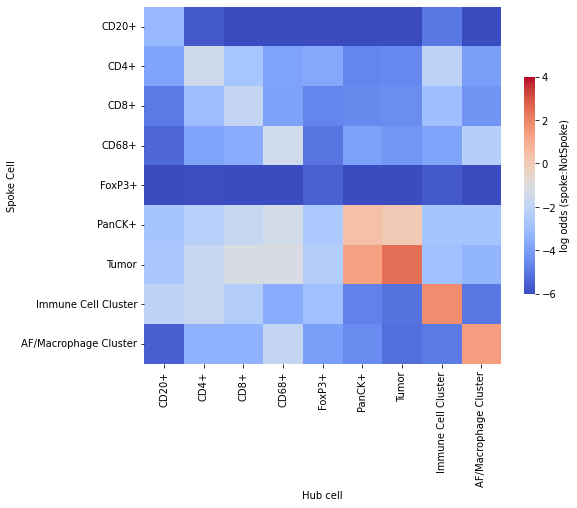

In [16]:
print(all_outs.shape)
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
temp = all_outs
# temp[np.isinf(all_outs)] = 4 #Value for cores where hub cell only connects to one type of spoke cell (probably low n)
m_out = np.nanmean(temp,axis=2)
# m_out = zscore(m_out)
ax = connection_heatmap(m_out,cell_names)
# plt.imshow()


# Load enough data to make this interesting

In [17]:
fns = pd.read_csv('/mnt/results/neighborhoods/fns_whole_core_deltri_n-305_qc-50_dist-25_v2.csv')
all_core_codes = tls.seg_fn_to_unique_tma_code(fns.fn)
connections = np.load('/mnt/results/neighborhoods/log_odds_whole_core_deltri_n-305_qc-50_dist-25_v2.npy')
tls_full = pd.read_pickle('/mnt/results/all_tls_features_with_clinical_UMAP_size_and_pattern.pkl')
tma_id = np.unique(tls_full.loc[:,'unique_TMA_Code'])
n_tma = len(tma_id)
has_tls = ~ (tls_full['tls_id'].values == "None")
good_tls = tls_full['tls_is_good'].values
use_tls =  good_tls
idx = tls_full.loc[use_tls,'unique_TMA_Code'].isin(all_core_codes)
print('Unique TLS found in cores n =',np.sum(idx.values))
tls_cores = np.unique(tls_full.loc[use_tls,'unique_TMA_Code'].values)
print('Unique cores in TLS n =', len(tls_cores))
tls_core_idx = pd.Series(all_core_codes).isin(tls_cores).values
print('Unique TLS cores found in all cores n =' ,np.sum(tls_core_idx))

Unique TLS found in cores n = 163
Unique cores in TLS n = 90
Unique TLS cores found in all cores n = 90


# Connections: Compare TLS to No TLS

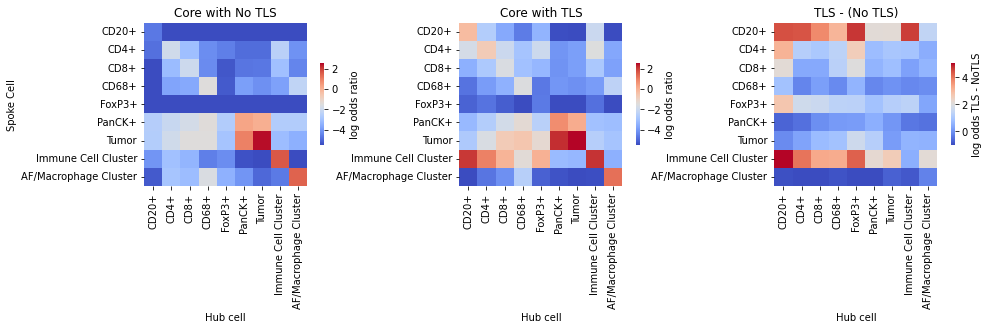

In [18]:
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
use_cells = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
      ]
use = np.array(pd.Series(cell_names).isin(use_cells))
fig = plt.figure(figsize=[16,3],)
ids = [~tls_core_idx, tls_core_idx]
labs = ['Core with No TLS', 'Core with TLS']
i = 1   
keep = []
for idx,lab in zip(ids,labs):
    ax = fig.add_subplot(1,3,i,aspect='equal')    
    temp = connections[:,:,idx]
    temp = temp[use,:,:]
    temp = temp[:,use,:]
    m_out = np.nanmean(temp,axis=2) # m_out = zscore(m_out)
    keep.append(m_out)
    if i > 1:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    ax = connection_heatmap(m_out, 
                            np.array(cell_names)[use],
                            ylabel = ylabel,
                            label='log odds ratio',
                            vmin = -5.5,
                            vmax = 2.5,
                            ax=ax)
    ax.set_title(lab)
    i = i +1
ax = fig.add_subplot(1,3,i,aspect='equal')
tls_diff = keep[1]-keep[0]
ax = connection_heatmap(tls_diff,
                        np.array(cell_names)[use],
                        ax = ax,
                        ylabel='',
                        vmin = -1,
                        vmax = 5,
                        label = 'log odds TLS - NoTLS')
ax.set_title('TLS - (No TLS)');

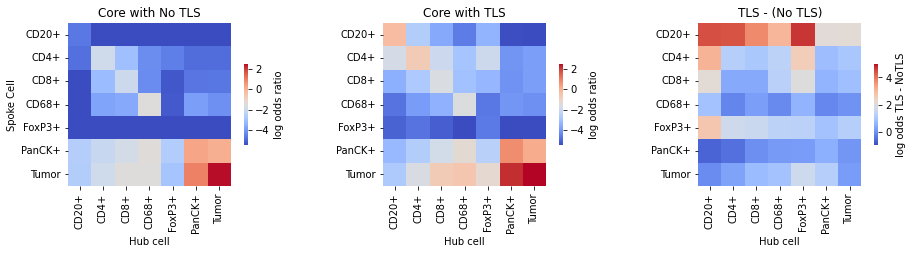

In [19]:
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
use_cells = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
      ]

#More stringent ? no not really different
# tls_and_agg_cores = np.unique(tls_full.loc[has_tls,'unique_TMA_Code'].values) #includes non-tls aggregates
# no_tls_core_idx = ~pd.Series(all_core_codes).isin(tls_and_agg_cores).values
# print(np.sum(no_tls_core_idx))

no_tls_core_idx = ~tls_core_idx
use = np.array(pd.Series(cell_names).isin(use_cells))
fig = plt.figure(figsize=[16,3],)
ids = [no_tls_core_idx, tls_core_idx]
labs = ['Core with No TLS', 'Core with TLS']
i = 1   
keep = []
for idx,lab in zip(ids,labs):
    ax = fig.add_subplot(1,3,i,aspect='equal')    
    temp = connections[:,:,idx]
    temp = temp[use,:,:]
    temp = temp[:,use,:]
    m_out = np.nanmean(temp,axis=2) # m_out = zscore(m_out)
    keep.append(m_out)
    if i > 1:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    ax = connection_heatmap(m_out, 
                            np.array(cell_names)[use],
                            ylabel = ylabel,
                            vmin = -5.5,
                            vmax = 2.5,
                            label='log odds ratio',
                            ax=ax)
    ax.set_title(lab)
    i = i +1
ax = fig.add_subplot(1,3,i,aspect='equal')
tls_diff = keep[1]-keep[0]
ax = connection_heatmap(tls_diff,
                        np.array(cell_names)[use],
                        ax = ax,
                        ylabel='',
                        vmin = -1,
                        vmax = 5,
                        label = 'log odds TLS - NoTLS')
ax.set_title('TLS - (No TLS)');

# TODO:
- refine TLS
- perform connectivity analysis just on TLS cell regions
- cluster TLS

In [114]:
tls_full.head()

,PID,Condition,Block,TMA_Number,TMA_Core,segmented_TMA_Code,unique_TMA_Code,PID.1,CommentBD,Sex,...,tls_neighbor_per_CD68+,tls_neighbor_xy_CD68+,tls_neighbor_per_FoxP3+,tls_neighbor_xy_FoxP3+,tls_neighbor_per_PanCK+,tls_neighbor_xy_PanCK+,pattern_based_UMAP_cluster_ids,pattern_based_UMAP_0,pattern_based_UMAP_1,is_TMA01
0,00044-3,adj,G,1.0,"1,I","[1,1,I]","TMA01_Core[1,1,I]",443.0,NaN,female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,00044-3,primary,H,1.0,"1,C","[1,1,C]","TMA01_Core[1,1,C]",443.0,NaN,female,...,1.565858,"[[40607.3, 6456.4], [40909.1, 6500.1], [40856....",0.030703,"[[40967.8, 6718.9]]",0.153516,"[[40351.2, 6474.3], [40679.4, 6727.4], [40907....",NaN,NaN,NaN,True
2,00044-3,primary,H,1.0,"1,C","[1,1,C]","TMA01_Core[1,1,C]",443.0,NaN,female,...,1.359867,"[[39949.0, 6504.6], [40333.8, 6657.7], [40315....",0.000000,[],2.321725,"[[40183.7, 6430.0], [39843.6, 6579.2], [39848....",NaN,NaN,NaN,True
3,00044-3,primary,H,1.0,"1,C","[1,1,C]","TMA01_Core[1,1,C]",443.0,NaN,female,...,0.431144,"[[40909.1, 6500.1], [40856.4, 6536.4], [40898....",0.025361,"[[40967.8, 6718.9]]",2.891200,"[[40692.8, 7028.2], [40638.1, 7077.9], [40729....",NaN,NaN,NaN,True
4,00044-3,primary,H,1.0,"1,C","[1,1,C]","TMA01_Core[1,1,C]",443.0,NaN,female,...,0.830406,"[[40172.7, 6744.8], [40111.1, 6765.1], [40295....",0.000000,[],5.301821,"[[40061.3, 6844.2], [39932.6, 6872.5], [40328....",NaN,NaN,NaN,True


# Plot core-level connection matrix by spatial group

In [120]:
print(np.sum(use),cid)

30 0


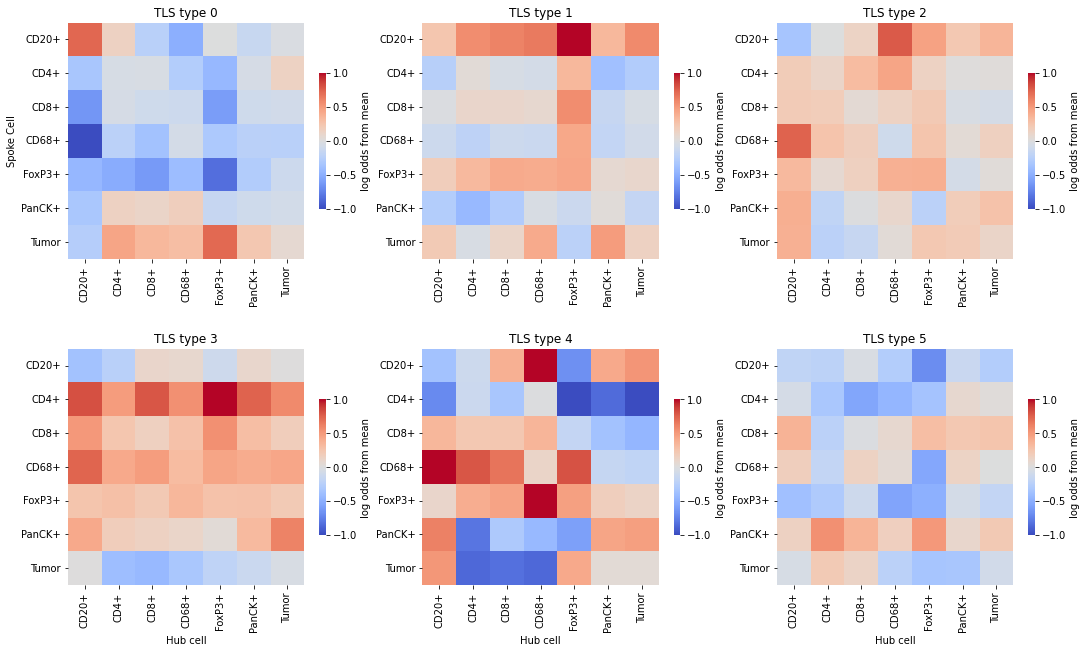

In [24]:
use_cells = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           # 'Immune Cell Cluster',
           # 'AF/Macrophage Cluster',
      ]
use = np.array(pd.Series(cell_names).isin(use_cells))
fig = plt.figure(figsize=[18,11],)
cluster_ids = [x for x in range(0,6)]
labs = [str(x) for x in cluster_ids]
i = 1   
keep = []
temp = connections[:,:, tls_core_idx]
temp = temp[use,:,:]
temp = temp[:,use,:]
m_out_all = np.nanmean(temp,axis=2) # m_out = zscore(m_out)

mean_tls =  np.nanmean(connections,axis=2)

# ax = connection_heatmap(m_out,cell_names)
for cid,lab in zip(cluster_ids,labs):
    ax = fig.add_subplot(2,3,i,aspect='equal') 
    # 
    cluster_idx = tls_full.loc[:,'pattern_based_UMAP_cluster_ids'].values == cid
    use_tls = good_tls & cluster_idx
    tls_cores = np.unique(tls_full.loc[use_tls,'unique_TMA_Code'].values)
    tls_core_type_idx = pd.Series(all_core_codes).isin(tls_cores).values    
    temp = connections[:,:,tls_core_type_idx]
    temp = temp[use,:,:]
    temp = temp[:,use,:]
    m_out = np.nanmean(temp,axis=2) # m_out = zscore(m_out)
    keep.append(m_out)
    if i > 1:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    
    ax = connection_heatmap(m_out-m_out_all, 
                            np.array(cell_names)[use],
                            ylabel = ylabel,
                            label='log odds from mean',
                            vmin = -1,# -5.5,
                            vmax = 1, #2.5,
                            ax=ax)
    if i < 4:
        # ax.set_xticks([])
        ax.set_xlabel('')
        
    ax.set_title('TLS type %s' % lab)
    i = i +1
